In [ ]:
!pip install matplotlib
pip install nltk
pip install pandas
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.2 MB/s eta 0:00:001.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import nltk
# import random

# # Descargar corpus de palabras si es necesario
# nltk.download('words')
# from nltk.corpus import words

# # Obtener lista de palabras en inglés
# lista_palabras = words.words()

# # Generar 1000 frases aleatorias, cada una con entre 1 y 25 elementos
# frases_random = []
# for _ in range(10):
#     longitud = random.randint(1, 25)
#     frase = []
#     for _ in range(longitud):
#         if random.random() < 0.05:  # 20% de probabilidad de número (ajustable)
#             frase.append(str(random.randint(0, 999999)))
#         else:
#             frase.append(random.choice(lista_palabras))
#     frases_random.append(' '.join(frase))

# with open("frases.txt", "w", encoding="utf-8") as f:
#     for frase in frases_random:
#         f.write(frase + "\n")


with open("frases.txt", "r", encoding="utf-8") as f:
    frases = [line.strip() for line in f]


In [2]:
# import os
# import re
# import json
# from collections import defaultdict
# from matplotlib import font_manager

# fuentes = []

# # Palabras clave a excluir
# excluir_keywords = [
#     "math", "Math", "MathJax", "CM", "cm", "stmary", "esint", "rsfs", "wasy",
#     "msam", "msbm", "TeX", "barcode", "icon", "icons", "symbol",
#     "FontAwesome", "Material", "Noto Emoji", "Typewriter", "Zapf", "Dingbats",
#     "dsrom10", "eufm10", "feather", "icomoon-feather","Hack"
# ]

# # Obtener rutas de fuentes del sistema
# fuentes_rutas = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# fuentes_dict = defaultdict(list)

# for ruta in fuentes_rutas:
#     try:
#         ruta_abs = os.path.abspath(os.path.realpath(ruta))  # Normaliza y resuelve
#         prop = font_manager.FontProperties(fname=ruta_abs)
#         nombre = prop.get_name()
#         if not any(re.search(k, nombre, re.IGNORECASE) for k in excluir_keywords):
#             fuentes.append(ruta_abs)
#     except Exception:
#         continue

# for fuente in fuentes :
#     print(fuente)


fuentes = [
    # OCR
    "/home/alberto/.local/share/fonts/ocr-a-std.otf",
    "/home/alberto/.local/share/fonts/ocrbregular.ttf",
    "/home/alberto/.local/share/fonts/ocraregular.ttf",
    "/home/alberto/.local/share/fonts/ocr-a-extended.ttf",
    
    # Súper conocidas
    "/home/alberto/.local/share/fonts/arial.ttf",  # Arial
    "/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf",  # Noto
    "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",  # DejaVu
    "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
    "/usr/share/fonts/truetype/lato/Lato-Regular.ttf",
    "/usr/share/fonts/truetype/quicksand/Quicksand-Regular.ttf",
    "/usr/share/fonts/truetype/freefont/FreeSans.ttf",
    "/usr/share/fonts/opentype/urw-base35/NimbusSans-Regular.otf",

]



## Generacion csv para tesseract

In [ ]:
import base64
import numpy as np
from PIL import Image, ImageDraw, ImageFont

import easyocr
import pytesseract



def ocultar(datos, tamaño,fuente,anchura, altura_imagen=None, anchura_imagen=None):
    """
    Oculta los datos en una imagen en formato de texto.

    Si los datos están cifrados, se codifican en base64 antes de ser escritos. Si no están cifrados,
    se escriben tal cual. El texto se ajusta al tamaño de la imagen, dividiendo las líneas si es necesario.

    Args:
        datos (bytes): Los datos a ocultar en la imagen.
        altura_imagen (int, optional): La altura de la imagen en píxeles. Si es None, se calcula automáticamente.
        anchura_imagen (int, optional): La anchura de la imagen en píxeles. Si es None, se usa un valor por defecto.

    Returns:
        imagen (PIL.Image): La imagen con los datos ocultos como texto.
        str: El formato de la imagen.

    Raises:
        Exception: Si no es posible ajustar los datos en la imagen debido a la falta de espacio.
    """
    # Cargamos la configuración
    tamaño_fuente = tamaño
    anchura_maxima = anchura
    ruta_fuente = fuente
    fuente = ImageFont.truetype(ruta_fuente, tamaño_fuente)
    
    # Definir la anchura máxima de las líneas
    if anchura_imagen is None:
        anchura_imagen = anchura_maxima
    else:
        anchura_maxima = anchura_imagen

    ancho_maximo_linea = anchura_imagen - 20  # Margen lateral de 10 píxeles a cada lado

    # Lista que contendrá las líneas de texto
    lineas_ajustadas = []

    if datos:
        # Comprobar si la palabra es demasiado larga para caber en una línea
        ancho_datos = fuente.getlength(datos)
        if ancho_datos > ancho_maximo_linea:
            # Dividir los datos en fragmentos que quepan en una línea
            fragmento = ""
            for caracter in datos:
                fragmento_prueba = fragmento + caracter
                ancho_fragmento = fuente.getlength(fragmento_prueba)
                if ancho_fragmento > ancho_maximo_linea:
                    lineas_ajustadas.append(fragmento)
                    fragmento = caracter
                else:
                    fragmento = fragmento_prueba
            if fragmento:
                lineas_ajustadas.append(fragmento)
        else:
            lineas_ajustadas.append(datos)

    # Calcular la altura necesaria si no se ha proporcionado
    altura_linea = tamaño_fuente + 5  # Altura de línea con margen
    altura_necesaria = (altura_linea * len(lineas_ajustadas)) + 20  # Espacio adicional para márgenes

    if altura_imagen is None:
        altura_imagen = altura_necesaria

    # Crear la imagen con las dimensiones calculadas
    imagen = Image.new('RGB', (anchura_imagen, altura_imagen), color='white')
    dibujo = ImageDraw.Draw(imagen)

    # Dibujar el texto en la imagen
    posicion_y = 10  # Margen superior
    for linea in lineas_ajustadas:
        if posicion_y + altura_linea > altura_imagen - 10:  # Detener si excede la altura de la imagen
            raise Exception("No es posible añadir tantos datos a la imagen")
        dibujo.text((10, posicion_y), linea, font=fuente, fill='black')
        posicion_y += altura_linea

    return imagen,None

def desocultar(imagen):
    a= pytesseract.image_to_string(imagen, config='--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/=')
    return a
import difflib

def similitud_sin_espacios(str1, str2):
    # Eliminar espacios
    s1 = str1.replace(" ", "")
    s2 = str2.replace(" ", "")
    
    # Comparador de secuencias
    secuencia = difflib.SequenceMatcher(None, s1, s2)
    
    # Ratio de similitud (entre 0 y 1) → lo convertimos a porcentaje
    return round(secuencia.ratio() * 100, 2)



In [ ]:
import os
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product, islice
from tqdm import tqdm

# Crear carpeta de salida
os.makedirs("./experimental/tesseract/", exist_ok=True)

# Parámetros
tope = 25
anchuras = list(range(800, 10800, 1000))
batch_size = 500  # 🔥 clave para no saturar
max_workers = 8   # ajusta a tu CPU

# Generar combinaciones de tareas
tareas = list(product(fuentes, frases, range(1, tope,2), anchuras))

def procesar(fuente, frase, i, anchura):
    try:
        imagen, _ = ocultar(frase, i, fuente, anchura)
        texto = desocultar(imagen)
        resultado = similitud_sin_espacios(frase, texto)
        return {
            "tamaño": i,
            "fuente": fuente.split("/")[-1].split(".")[0],
            "anchura": anchura,
            "resultado": resultado,
            "frase_original": frase,
            "texto_extraido": texto.strip()
        }
    except Exception as e:
        return None

def por_bloques(lista, tamaño):
    for i in range(0, len(lista), tamaño):
        yield lista[i:i + tamaño]

# Procesamiento por bloques
resultados = []
total_tareas = len(tareas)
print(f"Procesando {total_tareas} tareas en bloques de {batch_size}...")

for batch in tqdm(por_bloques(tareas, batch_size), total=(total_tareas // batch_size) + 1, desc="Bloques"):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(procesar, *args): args for args in batch}
        for future in as_completed(futures):
            res = future.result()
            if res:
                resultados.append(res)

# Guardar resultados
df = pd.DataFrame(resultados)
csv_path = "./experimental/tesseract/resultados.csv"
df.to_csv(csv_path, index=False, encoding="utf-8")

print(f"\n✅ Resultados guardados en: {csv_path}")


## Generacion Easey OCR

In [3]:
import base64
import numpy as np
from PIL import Image, ImageDraw, ImageFont

import easyocr
import pytesseract



def ocultar(datos, tamaño,fuente,anchura, altura_imagen=None, anchura_imagen=None):
    """
    Oculta los datos en una imagen en formato de texto.

    Si los datos están cifrados, se codifican en base64 antes de ser escritos. Si no están cifrados,
    se escriben tal cual. El texto se ajusta al tamaño de la imagen, dividiendo las líneas si es necesario.

    Args:
        datos (bytes): Los datos a ocultar en la imagen.
        altura_imagen (int, optional): La altura de la imagen en píxeles. Si es None, se calcula automáticamente.
        anchura_imagen (int, optional): La anchura de la imagen en píxeles. Si es None, se usa un valor por defecto.

    Returns:
        imagen (PIL.Image): La imagen con los datos ocultos como texto.
        str: El formato de la imagen.

    Raises:
        Exception: Si no es posible ajustar los datos en la imagen debido a la falta de espacio.
    """
    # Cargamos la configuración
    tamaño_fuente = tamaño
    anchura_maxima = anchura
    ruta_fuente = fuente
    fuente = ImageFont.truetype(ruta_fuente, tamaño_fuente)

    datos_bytes= datos.encode("utf-8")
    base64_bytes = base64.b64encode(datos_bytes)
    datos = base64_bytes.decode("utf-8")
 
    
    # Definir la anchura máxima de las líneas
    if anchura_imagen is None:
        anchura_imagen = anchura_maxima
    else:
        anchura_maxima = anchura_imagen

    ancho_maximo_linea = anchura_imagen - 20  # Margen lateral de 10 píxeles a cada lado

    # Lista que contendrá las líneas de texto
    lineas_ajustadas = []

    if datos:
        # Comprobar si la palabra es demasiado larga para caber en una línea
        ancho_datos = fuente.getlength(datos)
        if ancho_datos > ancho_maximo_linea:
            # Dividir los datos en fragmentos que quepan en una línea
            fragmento = ""
            for caracter in datos:
                fragmento_prueba = fragmento + caracter
                ancho_fragmento = fuente.getlength(fragmento_prueba)
                if ancho_fragmento > ancho_maximo_linea:
                    lineas_ajustadas.append(fragmento)
                    fragmento = caracter
                else:
                    fragmento = fragmento_prueba
            if fragmento:
                lineas_ajustadas.append(fragmento)
        else:
            lineas_ajustadas.append(datos)

    # Calcular la altura necesaria si no se ha proporcionado
    altura_linea = tamaño_fuente + 5  # Altura de línea con margen
    altura_necesaria = (altura_linea * len(lineas_ajustadas)) + 20  # Espacio adicional para márgenes

    if altura_imagen is None:
        altura_imagen = altura_necesaria

    # Crear la imagen con las dimensiones calculadas
    imagen = Image.new('RGB', (anchura_imagen, altura_imagen), color='white')
    dibujo = ImageDraw.Draw(imagen)

    # Dibujar el texto en la imagen
    posicion_y = 10  # Margen superior
    for linea in lineas_ajustadas:
        if posicion_y + altura_linea > altura_imagen - 10:  # Detener si excede la altura de la imagen
            raise Exception("No es posible añadir tantos datos a la imagen")
        dibujo.text((10, posicion_y), linea, font=fuente, fill='black')
        posicion_y += altura_linea

    return imagen,None

def desocultar(imagen):
    
    imagen_array = np.array(imagen)
    
    # Crear el lector OCR
    reader = easyocr.Reader(['en'], gpu=True)  

    # Extraer texto de la imagen
    resultado = reader.readtext(imagen_array, detail=0, allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/=') 
    texto_extraido = ''.join(resultado)  # Obtener solo el texto
    return texto_extraido
    
import difflib

def similitud_sin_espacios(str1, str2):
    # Eliminar espacios
    s1 = str1.replace(" ", "")
    s2 = str2.replace(" ", "")
    
    # Comparador de secuencias
    secuencia = difflib.SequenceMatcher(None, s1, s2)
    
    # Ratio de similitud (entre 0 y 1) → lo convertimos a porcentaje
    return round(secuencia.ratio() * 100, 2)



In [4]:
import os
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import product, islice
from tqdm import tqdm

# Crear carpeta de salida
os.makedirs("./experimental/easy/", exist_ok=True)

# Parámetros
tope = 25
anchuras = list(range(800, 10800,1000))
batch_size = 100  # 🔥 clave para no saturar
max_workers = 8   # ajusta a tu CPU

# Generar combinaciones de tareas
tareas = list(product(fuentes, frases, range(1, tope,2), anchuras))

def procesar(fuente, frase, i, anchura):
    try:
        imagen, _ = ocultar(frase, i, fuente, anchura)
        #imagen.save(f"./experimental/easy/{i}_{fuente.split('/')[-1].split('.')[0]}_{anchura}_{frase.split(' ')}.png")
        texto = desocultar(imagen)
        datos_bytes= frase.encode("utf-8")
        base64_bytes = base64.b64encode(datos_bytes)
        frase = base64_bytes.decode("utf-8")

        resultado = similitud_sin_espacios(frase, texto)
        return {
            "tamaño": i,
            "fuente": fuente.split("/")[-1].split(".")[0],
            "anchura": anchura,
            "resultado": resultado,
            "frase_original": frase,
            "texto_extraido": texto.strip()
        }
    except Exception as e:
        print(e)

def por_bloques(lista, tamaño):
    for i in range(0, len(lista), tamaño):
        yield lista[i:i + tamaño]

# Procesamiento por bloques
resultados = []
total_tareas = len(tareas)
print(f"Procesando {total_tareas} tareas en bloques de {batch_size}...")

for batch in tqdm(por_bloques(tareas, batch_size), total=(total_tareas // batch_size) + 1, desc="Bloques"):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(procesar, *args): args for args in batch}
        for future in as_completed(futures):
            res = future.result()
            if res:
                resultados.append(res)

# Guardar resultados
df = pd.DataFrame(resultados)
csv_path = "./experimental/easy/resultados.csv"
df.to_csv(csv_path, index=False, encoding="utf-8")

print(f"\n✅ Resultados guardados en: {csv_path}")


Procesando 14400 tareas en bloques de 100...


Bloques:   0%|          | 0/145 [00:00<?, ?it/s]

Bloques:  52%|█████▏    | 75/145 [39:35<36:09, 30.99s/it]  

CUDA out of memory. Tried to allocate 46.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 25.62 MiB is free. Process 361668 has 492.00 MiB memory in use. Process 361667 has 416.00 MiB memory in use. Including non-PyTorch memory, this process has 334.00 MiB memory in use. Process 361672 has 642.00 MiB memory in use. Process 361666 has 554.00 MiB memory in use. Process 361670 has 512.00 MiB memory in use. Process 361671 has 362.00 MiB memory in use. Process 361665 has 538.00 MiB memory in use. Of the allocated memory 179.52 MiB is allocated by PyTorch, and 62.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Bloques:  77%|███████▋  | 111/145 [58:55<18:32, 32.71s/it]

CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 49.62 MiB is free. Process 369737 has 510.00 MiB memory in use. Process 369738 has 486.00 MiB memory in use. Including non-PyTorch memory, this process has 274.00 MiB memory in use. Process 369741 has 486.00 MiB memory in use. Process 369735 has 522.00 MiB memory in use. Process 369736 has 568.00 MiB memory in use. Process 369739 has 482.00 MiB memory in use. Process 369742 has 498.00 MiB memory in use. Of the allocated memory 164.02 MiB is allocated by PyTorch, and 17.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Bloques:  99%|█████████▉| 144/145 [1:15:59<00:31, 31.67s/it]


✅ Resultados guardados en: ./experimental/easy/resultados.csv


## Arreglo resultado

In [13]:
import pandas as pd
import difflib
import unicodedata
import re

# Función para limpiar el texto
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""
    texto = unicodedata.normalize('NFKD', texto)
    texto = ''.join(c for c in texto if not unicodedata.combining(c))
    texto = re.sub(r'\W+', '', texto)
    return texto.lower()

# Función para calcular similitud
def similitud_sin_espacios(str1, str2):
    s1 = limpiar_texto(str1)
    s2 = limpiar_texto(str2)
    secuencia = difflib.SequenceMatcher(None, s1, s2)
    return round(secuencia.ratio() * 100, 2)

# Cargar CSVs
df_easy = pd.read_csv("./experimental/easy/resultados.csv")
df_tesse = pd.read_csv("./experimental/tesseract/resultados.csv")

# Aplicar a cada fila: sobrescribir o añadir la columna resultado
df_easy["resultado"] = df_easy.apply(
    lambda row: similitud_sin_espacios(row["frase_original"], row["texto_extraido"]), axis=1)

df_tesse["resultado"] = df_tesse.apply(
    lambda row: similitud_sin_espacios(row["frase_original"], row["texto_extraido"]), axis=1)

# (Opcional) Guardar nuevamente
df_easy.to_csv("./experimental/easy/resultados.csv", index=False)
df_tesse.to_csv("./experimental/tesseract/resultados.csv", index=False)





## Analisis Tesseract

In [41]:
import pandas as pd
df_tesse = pd.read_csv("./experimental/tesseract/resultados.csv")
df = df_tesse

## Analisi EasyOCr

In [ ]:
import pandas as pd
df_easy = pd.read_csv("./experimental/easy/resultados.csv")
df = df_easy

### 1.0 Casos en los que no ha generado nada

In [32]:
df_nulos = df[df.isnull().any(axis=1)]

print("Número de filas con valores nulos:", len(df_nulos))
print(df.isnull().sum())
df_nulos


Número de filas con valores nulos: 4430
tamaño               0
fuente               0
anchura              0
resultado            0
frase_original       0
texto_extraido    4430
dtype: int64


,tamaño,fuente,anchura,resultado,frase_original,texto_extraido
0,1,ocr-a-std,7800,0.0,hardpan diluvianism 756819 quintary unsaintlik...,NaN
1,1,ocr-a-std,3800,0.0,hardpan diluvianism 756819 quintary unsaintlik...,NaN
2,1,ocr-a-std,1800,0.0,hardpan diluvianism 756819 quintary unsaintlik...,NaN
3,1,ocr-a-std,5800,0.0,hardpan diluvianism 756819 quintary unsaintlik...,NaN
4,1,ocr-a-std,4800,0.0,hardpan diluvianism 756819 quintary unsaintlik...,NaN
...,...,...,...,...,...,...
14315,7,NimbusSans-Regular,5800,0.0,grogginess,NaN
14316,7,NimbusSans-Regular,6800,0.0,grogginess,NaN
14318,7,NimbusSans-Regular,8800,0.0,grogginess,NaN
14319,7,NimbusSans-Regular,7800,0.0,grogginess,NaN


### 2.0 resultado por tamaño

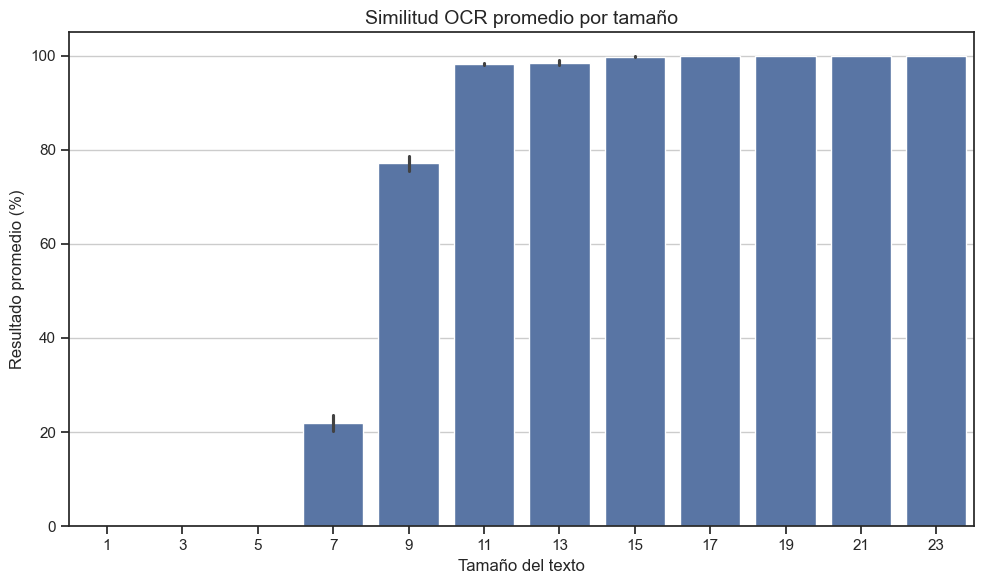

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo visual
sns.set(style="ticks")

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x="tamaño", y="resultado", data=df, estimator="mean")

# Personalización
plt.title("Similitud OCR promedio por tamaño", fontsize=14)
plt.xlabel("Tamaño del texto", fontsize=12)
plt.ylabel("Resultado promedio (%)", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(True, axis='y')

# Mostrar
plt.show()

3.0 Resultado por Fuente

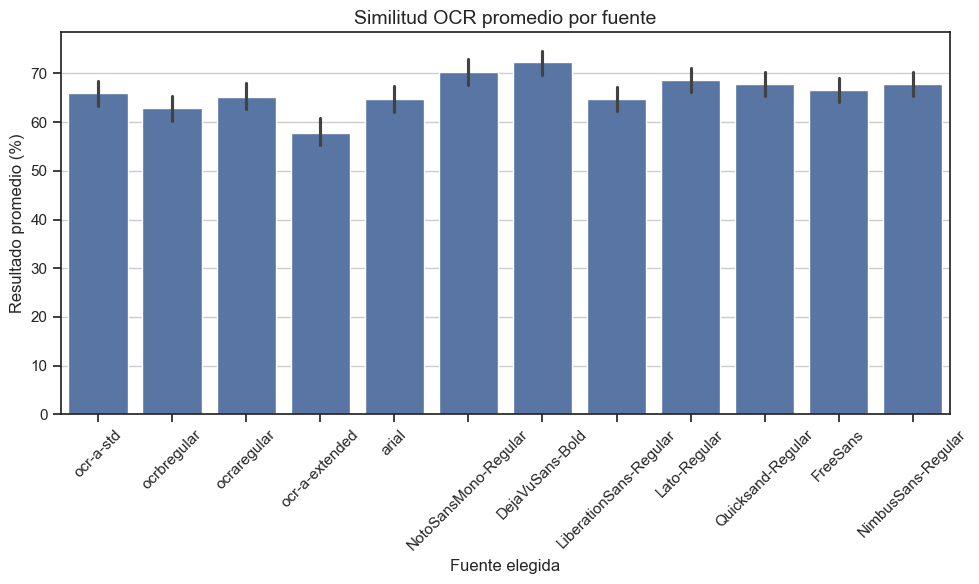

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo visual
sns.set(style="ticks")

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x="fuente", y="resultado", data=df, estimator="mean")

# Personalización
plt.title("Similitud OCR promedio por fuente", fontsize=14)
plt.xlabel("Fuente elegida", fontsize=12)
plt.ylabel("Resultado promedio (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')

# Mostrar
plt.show()

4.0 resultado por Anchura

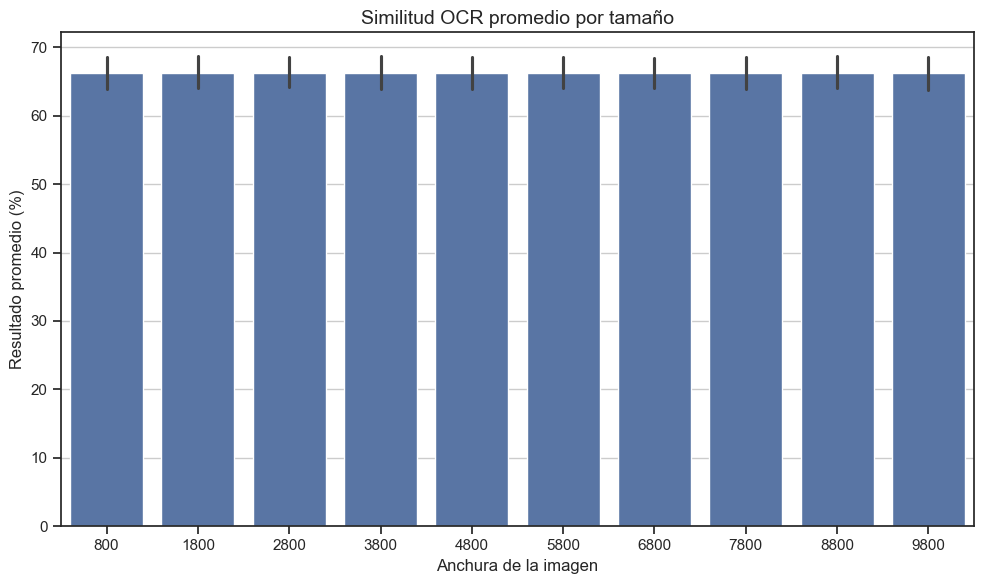

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo visual
sns.set(style="ticks")

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x="anchura", y="resultado", data=df, estimator="mean")

# Personalización
plt.title("Similitud OCR promedio por tamaño", fontsize=14)
plt.xlabel("Anchura de la imagen", fontsize=12)
plt.ylabel("Resultado promedio (%)", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(True, axis='y')

# Mostrar
plt.show()